In [1248]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy.special import erfc
from scipy import stats
from sympy import *

sys.path.append('AppStat2023/External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [1249]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [1250]:
r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

save_plots = False
verbose = True

In [1251]:
def fit_and_plot(f, x, y, sy, par_guess, labels):
    Minuit.print_level = 1

    chi2fit = Chi2Regression(f, x, y, sy)

    minuit_chi2 = Minuit(chi2fit, **par_guess)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output


    for name in minuit_chi2.parameters :
        value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value = len(y) - minuit_chi2.nfit

    Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

    fig, ax = plt.subplots(figsize=(9, 6))  # figsize is in inches
    ax.errorbar(x, y, yerr=sy, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

    # Set the figure texts; xlabel, ylabel and title.
    ax.set(xlabel=f"{labels[0]}", # the label of the y axis
        ylabel=f"{labels[1]}",  # the label of the y axis
        title=f"{labels[2]}")

    # Adding fit function to plot:
    x_axis = np.linspace(np.min(x), np.max(x), 1000)
    ax.plot(x_axis, f(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

    # Adding fit results to plot:
    d = {'Chi2':     minuit_chi2.fval  ,
        'ndf':      len(y)-minuit_chi2.nfit,
        'Prob':     stats.chi2.sf(minuit_chi2.fval, len(y)-minuit_chi2.nfit),
        }

    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.62, 0.95, text, ax, fontsize=12)

    ax.legend(loc='upper left', fontsize=12);
    fig.tight_layout()

In [1252]:
# Calculate ROC curve from two histograms (hist1 is signal, hist2 is background):
def calc_ROC(hist1, hist2) :

    # First we extract the entries (y values) and the edges of the histograms:
    # Note how the "_" is simply used for the rest of what e.g. "hist1" returns (not really of our interest)
    y_sig, x_sig_edges = hist1 
    y_bkg, x_bkg_edges = hist2
    
    # Check that the two histograms have the same x edges:
    if np.array_equal(x_sig_edges, x_bkg_edges) :
        
        # Extract the center positions (x values) of the bins (both signal or background works - equal binning)
        x_centers = 0.5*(x_sig_edges[1:] + x_sig_edges[:-1])
        
        # Calculate the integral (sum) of the signal and background:
        integral_sig = y_sig.sum()
        integral_bkg = y_bkg.sum()
    
        # Initialize empty arrays for the True Positive Rate (TPR) and the False Positive Rate (FPR):
        TPR = np.zeros_like(y_sig) # True positive rate (sensitivity)
        FPR = np.zeros_like(y_sig) # False positive rate ()
        
        # Loop over all bins (x_centers) of the histograms and calculate TN, FP, FN, TP, FPR, and TPR for each bin:
        for i, x in enumerate(x_centers): 
            
            # The cut mask
            cut = (x_centers < x)
            
            # True positive
            TP = np.sum(y_sig[~cut]) / integral_sig    # True positives
            FN = np.sum(y_sig[cut]) / integral_sig     # False negatives
            TPR[i] = TP / (TP + FN)                    # True positive rate
            
            # True negative
            TN = np.sum(y_bkg[cut]) / integral_bkg      # True negatives (background)
            FP = np.sum(y_bkg[~cut]) / integral_bkg     # False positives
            FPR[i] = FP / (FP + TN)                     # False positive rate            
            
        return FPR, TPR
    
    else:
        AssertionError("Signal and Background histograms have different bins and/or ranges")

### Problem 1.1

In [1253]:
mu = 50
sigma = 20

In [1254]:
frac = 1 - (stats.norm.cdf(55, mu, sigma) + stats.norm.sf(65, mu, sigma))
print(f"The fraction of students that get a score in test A in the range [55,65] is {frac:.4f}.")

The fraction of students that get a score in test A in the range [55,65] is 0.1747.


In [1255]:
N = 120
sigma_mean = sigma / np.sqrt(N)
print(f"From {N} B test scores, the uncertainty on the mean is {sigma_mean:.3f}.")

From 120 B test scores, the uncertainty on the mean is 1.826.


In [1256]:
def calculate_integral(rho_AB, mu=mu, sigma=sigma):
    cov = np.array([[sigma**2, rho_AB*sigma**2],
                    [rho_AB*sigma**2, sigma**2]])

    integral = 1 - stats.multivariate_normal.cdf((70, 70), (mu, mu), cov)

    return integral


In [1257]:
no_corr = calculate_integral(rho_AB=0)
with_corr = calculate_integral(rho_AB=0.75)

cov = np.array([[20**2, 0],
                [0, 20**2]])

no_corr = (stats.norm.sf(70, 50, 20))**2
no_corr = 1 - stats.multivariate_normal.cdf((70, 70), (50, 50), cov)

print(f"With no correlation, the fraction that should get a score above 70 in both tests is {no_corr:.4f}.")
print(f"With the correlation rho=0.75, the fraction that should get a score above 70 in both tests is {with_corr:.4f}.")

With no correlation, the fraction that should get a score above 70 in both tests is 0.2921.
With the correlation rho=0.75, the fraction that should get a score above 70 in both tests is 0.2269.


In [1258]:
# simulation

N = 10000
N_above_both = 0

for i in range(N):

    score_A = np.random.normal(loc=mu, scale=sigma)
    score_B = np.random.normal(loc=mu, scale=sigma)

    if score_A > 70 and score_B > 70:
        N_above_both += 1

print(N_above_both/N)

0.0252


In [1259]:
# no correlation

N = 10000
N_above_both = 0
score_A_array = np.empty(N)
score_B_array = np.empty(N)

rho = 0
cov = np.array([[sigma**2, rho*sigma**2],
                [rho*sigma**2, sigma**2]])

for i in range(N):

    score_A, score_B = np.random.multivariate_normal((mu, mu), cov)
    score_A_array[i] = score_A
    score_B_array[i] = score_B

    if score_A > 70 and score_B > 70:
        N_above_both += 1

f = N_above_both/N
e_f = np.sqrt(f*(1-f)/N)

print(f"The fraction of students that get a score above 70 in both tests is {f} +- {e_f}")

The fraction of students that get a score above 70 in both tests is 0.0265 +- 0.0016061677994530959


In [1260]:
# with correlation

N = 10000
N_above_both = 0
score_A_array_cor = np.empty(N)
score_B_array_cor = np.empty(N)


rho = 0.75
cov = np.array([[sigma**2, rho*sigma**2],
                [rho*sigma**2, sigma**2]])

for i in range(N):

    score_A, score_B = np.random.multivariate_normal((mu, mu), cov)

    score_A_array_cor[i] = score_A
    score_B_array_cor[i] = score_B

    if score_A > 70 and score_B > 70:
        N_above_both += 1

f = N_above_both/N
e_f = np.sqrt(f*(1-f)/N)
print(f"The fraction of students that get a score above 70 in both tests is {f} +- {e_f}")

The fraction of students that get a score above 70 in both tests is 0.0875 +- 0.0028256636388643286


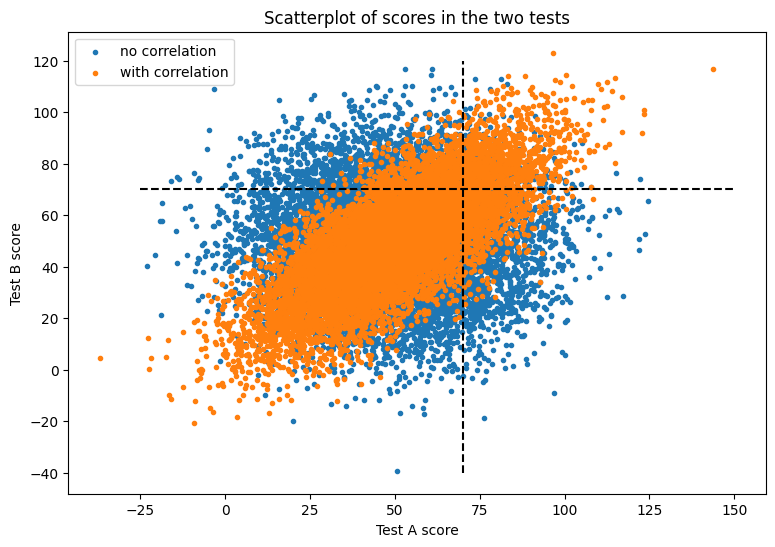

In [1261]:
plt.figure(figsize=(9,6))
plt.scatter(score_A_array, score_B_array, marker=".", label="no correlation")
plt.scatter(score_A_array_cor, score_B_array_cor, marker=".", label="with correlation")
plt.plot((70,70), (-40, 120), "k--")
plt.plot((-25,150), (70, 70), "k--")
#plt.xlim(-2,2)
#plt.ylim(-10,90)
plt.xlabel("Test A score")
plt.ylabel("Test B score")
plt.title("Scatterplot of scores in the two tests")
plt.legend()

### Problem 1.2

In [1262]:
p = 12/37
n = 20
k = 8

prob = stats.binom.sf(k, n, p)
print(f"The probability to win 8 or more times is {prob:.4f} = {prob*100:.2f} %.")

The probability to win 8 or more times is 0.1674 = 16.74 %.


### Problem 2.1

In [1263]:
def print_relation(R, name):
    """Print relation"""
    lprint(latex(Eq(symbols(name),R)))

def propagate_error(F, PAR, COV):

    variance_total = 0
    each_contrib = []

    for i in range(len(PAR)):
        for j in range(len(PAR)):
            variance = F.diff(PAR[i]) * F.diff(PAR[j]) * COV[i, j]
            variance_total += F.diff(PAR[i]) * F.diff(PAR[j]) * COV[i, j]
            each_contrib.append(variance)

    return sqrt(variance_total), each_contrib


In [1264]:
v_x, v_dx = 1.043, 0.014
v_y, v_dy = 0.07, 0.23

x, y = symbols("x, y")
dx, dy = symbols("sigma_x, sigma_y")

z1 = x * y * exp(-y)
z2 = (y + 1)**3 / (x - 1)

par = np.array([x, y])
cov = np.array([[dx**2, 0], [0, dy**2]])

print_relation(z1, "z_1")
dz1, contributions_z1 = propagate_error(z1, par, cov)
print_relation(dz1, "sigma_z_1")

print_relation(z2, "z_2")
dz2, _ = propagate_error(z2, par, cov)
print_relation(dz2, "sigma_z_2")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [1265]:
f_z1 = lambdify((x, y), z1)
f_dz1 = lambdify((x, y, dx, dy), dz1)
f_contributions_z1 = lambdify((x, y, dx, dy), contributions_z1)

f_z2 = lambdify((x, y), z2)
f_dz2 = lambdify((x, y, dx, dy), dz2)

print(f"z1 = {f_z1(v_x, v_y):.4f} +- {f_dz1(v_x, v_y, v_dx, v_dy):.4f}")
print(f"z2 = {f_z2(v_x, v_y):.4f} +- {f_dz2(v_x, v_y, v_dx, v_dy):.4f}")

z1 = 0.0681 +- 0.2080
z2 = 28.4894 +- 20.5804


In [1266]:
z1_variances = np.reshape(np.array(f_contributions_z1(v_x, v_y, v_dx, v_dy)), (2,2))

print(f"The contribution to the variance of z1 from x is {np.sqrt(z1_variances[0, 0]):.4}")
print(f"The contribution to the variance of z1 from y is {np.sqrt(z1_variances[1, 1]):.4} \n")
print("Hence, y contributes most to the uncertainty on z1.")

The contribution to the variance of z1 from x is 0.0009137
The contribution to the variance of z1 from y is 0.208 

Hence, y contributes most to the uncertainty on z1.


In [1267]:
# Now I add correlation

v_rho = 0.4
rho = symbols("rho")

cov = np.array([[dx**2, rho*dx*dy], [rho*dx*dy, dy**2]])

print_relation(z1, "z_1")
dz1, _ = propagate_error(z1, par, cov)
print_relation(dz1, "sigma_z_1")

print_relation(z2, "z_2")
dz2, _ = propagate_error(z2, par, cov)
print_relation(dz2, "sigma_z_2")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [1268]:
f_z1 = lambdify((x, y), z1)
f_dz1 = lambdify((x, y, dx, dy, rho), dz1)

f_z2 = lambdify((x, y), z2)
f_dz2 = lambdify((x, y, dx, dy, rho), dz2)

print(f"z1 = {f_z1(v_x, v_y):.4f} +- {f_dz1(v_x, v_y, v_dx, v_dy, v_rho):.4f}")
print(f"z2 = {f_z2(v_x, v_y):.4f} +- {f_dz2(v_x, v_y, v_dx, v_dy, v_rho):.4f}")

z1 = 0.0681 +- 0.2084
z2 = 28.4894 +- 16.9478


In [1269]:
N_exp = 10000
rho = 0.4

cov = np.array([[v_dx**2, rho*v_dx*v_dy],
                [rho*v_dx*v_dy, v_dy**2]])

x12_all = np.random.multivariate_normal([v_x, v_y], cov, size=N_exp)

y_all = (x12_all[:,1]+1)**3 / (x12_all[:,0]-1)

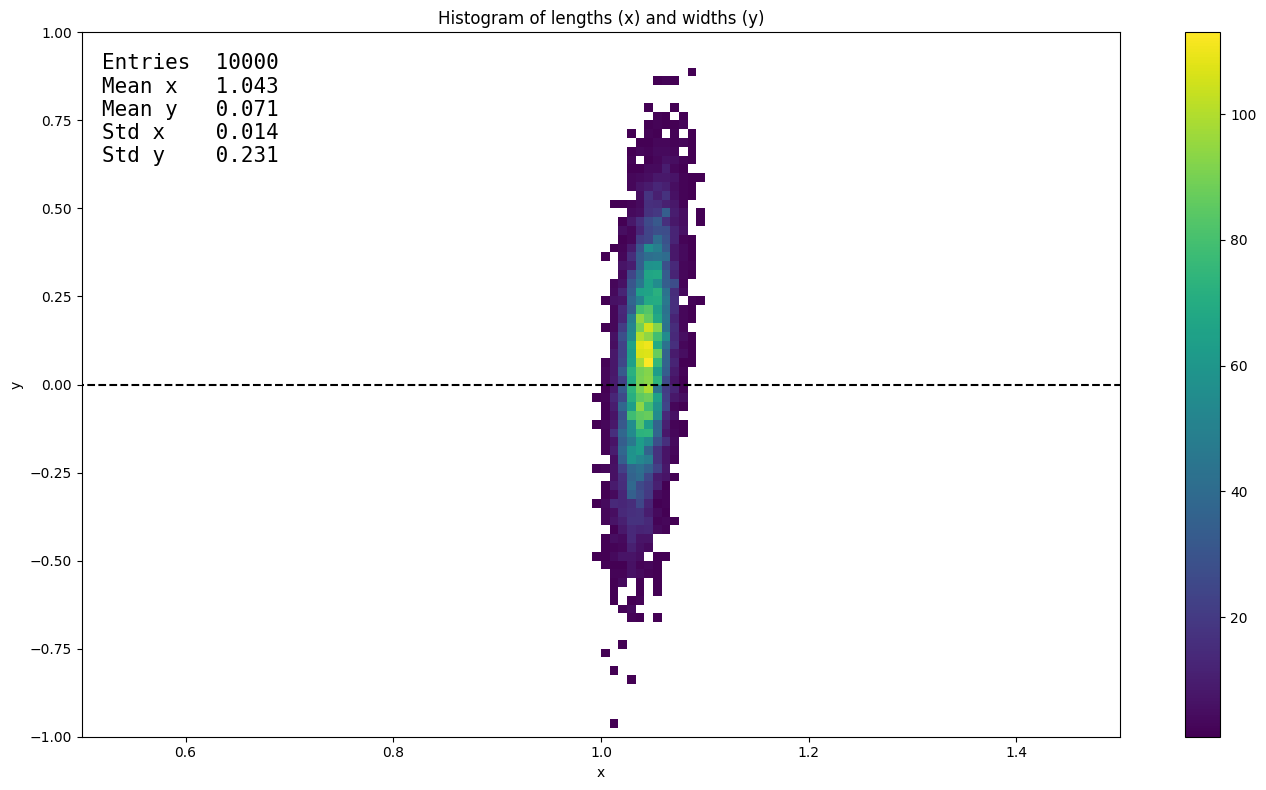

In [1270]:
fig, ax = plt.subplots(figsize=(14, 8))
counts, xedges, yedges, im = ax.hist2d(x12_all[:,0], x12_all[:,1], bins=[120, 80], range=[[0.5, 1.5], [-1, 1]], cmin=1)
ax.plot([0.0, 6.0], [0.0, 0.0], "--k")    # NOTE: Dashed black line from [x1, x2], [y1, y2] with dashed line
fig.colorbar(im)

ax.set(title='Histogram of lengths (x) and widths (y)',
       xlabel='x', 
       ylabel='y'
      )

d = {'Entries': len(x12_all),
     'Mean x': x12_all[:,0].mean(),
     'Mean y': x12_all[:,1].mean(),
     'Std x': x12_all[:,0].std(ddof=1),
     'Std y': x12_all[:,1].std(ddof=1),
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text, ax, fontsize=15);

fig.tight_layout()

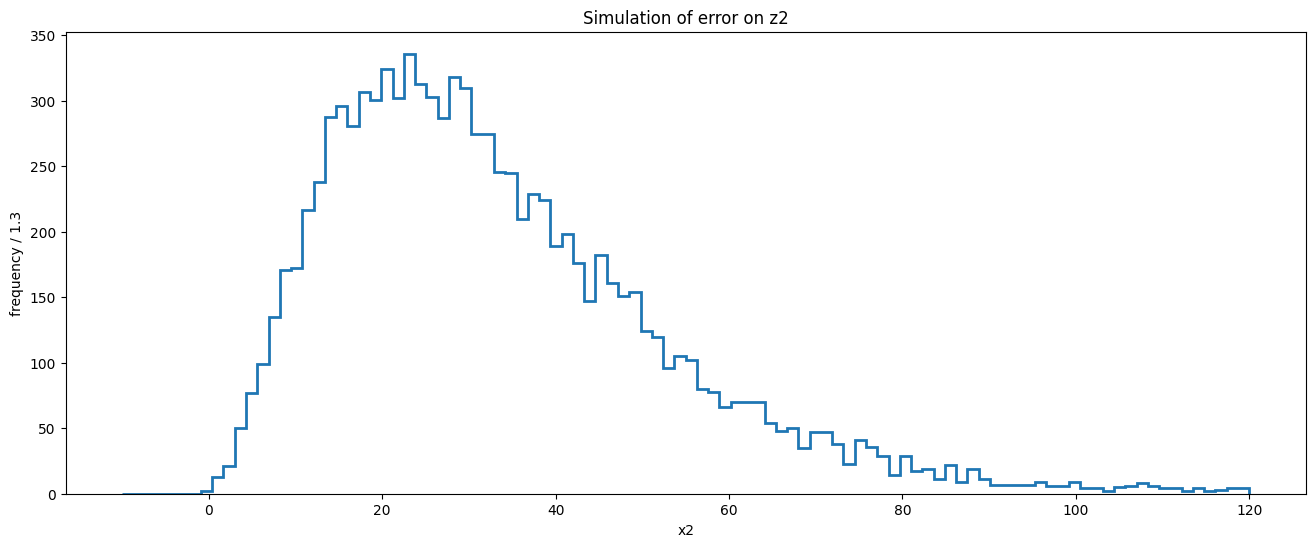

In [1271]:
nbins = 100
xmin, xmax = -10, 120.0
binwidth = (xmax-xmin)/nbins

fig2, ax2 = plt.subplots(figsize=(16, 6));
ax2.set(title="Simulation of error on z2", xlabel="x2", ylabel=f"frequency / {binwidth}")
counts, bin_edges, _ = ax2.hist(y_all, nbins, range=(xmin, xmax), histtype='step', linewidth=2)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)

In [1272]:
mean = y_all.mean()
std = y_all.std(ddof=1)
print(f"  Mean = {mean:5.3f},    Std = {std:5.3f}")

  Mean = 34.014,    Std = 29.250


Spearman correlation: 0.8383753543753544
Pearson correlation: 0.7228808185991332


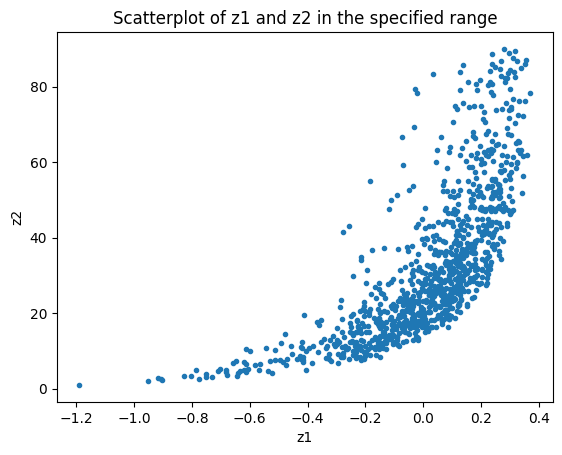

In [1273]:
z1_values = np.zeros(1000)
z2_values = np.zeros(1000)

for i in range(len(z1_values)):
    while True:

        x_try = np.random.normal(loc=v_x, scale=v_dx)
        y_try = np.random.normal(loc=v_y, scale=v_dy)

        z1_try = f_z1(x_try, y_try)
        z2_try = f_z2(x_try, y_try)

        if -2<=z1_try<=2 and -10<=z2_try<=90:
            break
    
    z1_values[i] = z1_try
    z2_values[i] = z2_try



plt.scatter(z1_values, z2_values, marker=".")
#plt.xlim(-2,2)
#plt.ylim(-10,90)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Scatterplot of z1 and z2 in the specified range")

spearman_cor = stats.spearmanr(z1_values, z2_values)[0]
print(f"Spearman correlation: {spearman_cor}")

pearson_cor = stats.pearsonr(z1_values, z2_values)[0]
print(f"Pearson correlation: {pearson_cor}")

### Problem 2.2

Text(0, 0.5, 'Density (g/cm^3)')

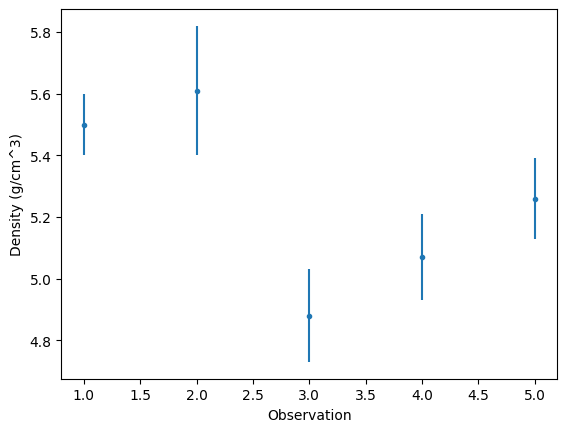

In [1274]:
density = np.array([5.50, 5.61, 4.88, 5.07, 5.26])
sig_density = np.array([0.10, 0.21, 0.15, 0.14, 0.13])

plt.errorbar(np.arange(1, 6), density, yerr=sig_density, fmt=".")
plt.xlabel("Observation")
plt.ylabel("Density (g/cm^3)")

In [1275]:
mean_weighted = np.sum(density/sig_density**2) / np.sum(1/sig_density**2)
err_weighted = np.sqrt(1 / np.sum(1/sig_density**2))

print(f"The combined result and uncertainty is ({mean_weighted:.4f} +- {err_weighted:.4f}) g/cm^3.")

The combined result and uncertainty is (5.2793 +- 0.0601) g/cm^3.


In [1276]:
chi2 = np.sum((density - mean_weighted)**2 / sig_density**2)

Ndof = len(density) - 1
chi2_prob = stats.chi2.sf(chi2, Ndof)

print(f"chi2 = {chi2}")
print(f"Number of degrees of freedom = {Ndof}")
print(f"The probability to get this result or something worse if the measurements are consistent is p = {chi2_prob:.4f}.")

chi2 = 16.694033875671384
Number of degrees of freedom = 4
The probability to get this result or something worse if the measurements are consistent is p = 0.0022.


In [1277]:
def z(density=density, sig_density=sig_density):
    return (density - np.mean(density)) / sig_density

z_values = z()
print(z_values)

[ 2.36        1.64761905 -2.56       -1.38571429 -0.03076923]


In [1278]:
# I remove the measurement which is most "off"

density_new = np.array([5.50, 5.61, 5.07, 5.26])
sig_density_new = np.array([0.10, 0.21, 0.14, 0.13])

mean_weighted_new = np.sum(density_new/sig_density_new**2) / np.sum(1/sig_density_new**2)
err_weighted_new = np.sqrt(1 / np.sum(1/sig_density_new**2))

chi2_new = np.sum((density_new - mean_weighted_new)**2 / sig_density_new**2)

Ndof_new = len(density_new) - 1
chi2_prob_new = stats.chi2.sf(chi2_new, Ndof_new)

print(f"The combined result and uncertainty is now ({mean_weighted_new:.4f} +- {err_weighted_new:.4f}) g/cm^3.")
print(f"chi2 = {chi2_new}")
print(f"Number of degrees of freedom = {Ndof_new}")
print(f"The probability to get this result or something worse if the measurements are consistent is p = {chi2_prob_new:.4f}.")

The combined result and uncertainty is now (5.3555 +- 0.0655) g/cm^3.
chi2 = 8.255084078989233
Number of degrees of freedom = 3
The probability to get this result or something worse if the measurements are consistent is p = 0.0410.


In [1279]:
# I remove the next measurement which is most "off"

density_new2 = np.array([5.50, 5.61, 5.26])
sig_density_new2 = np.array([0.10, 0.21, 0.13])

mean_weighted_new2 = np.sum(density_new2/sig_density_new2**2) / np.sum(1/sig_density_new2**2)
err_weighted_new2 = np.sqrt(1 / np.sum(1/sig_density_new2**2))

chi2_new2 = np.sum((density_new2 - mean_weighted_new2)**2 / sig_density_new2**2)

Ndof_new2 = len(density_new2) - 1
chi2_prob_new2 = stats.chi2.sf(chi2_new2, Ndof_new2)

print(f"The combined result and uncertainty is now ({mean_weighted_new2:.4f} +- {err_weighted_new2:.4f}) g/cm^3.")
print(f"chi2 = {chi2_new2}")
print(f"Number of degrees of freedom = {Ndof_new2}")
print(f"The probability to get this result or something worse if the measurements are consistent is p = {chi2_prob_new2:.4f}.")

The combined result and uncertainty is now (5.4356 +- 0.0742) g/cm^3.
chi2 = 2.92900412457851
Number of degrees of freedom = 2
The probability to get this result or something worse if the measurements are consistent is p = 0.2312.


In [1280]:
real_value = 5.514

chi2_realvalue = np.sum((density - real_value)**2 / sig_density**2)

Ndof_realvalue = len(density)
chi2_prob_realvalue = stats.chi2.sf(chi2_realvalue, Ndof_realvalue)

print(f"chi2 = {chi2_realvalue}")
print(f"Degrees of freedom = {Ndof_realvalue}")
print(f"The probability to get this result or something worse if the measurements are consistent with the real value is p = {chi2_prob_realvalue}.")

chi2 = 31.96876467952075
Degrees of freedom = 5
The probability to get this result or something worse if the measurements are consistent with the real value is p = 6.02647685140977e-06.


In [1281]:
t_statistic, p_value = stats.ttest_1samp(density, real_value, alternative="less")

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: -1.8620456557741227
P-value: 0.06803891224975642


In [1282]:
z_statistic = (mean_weighted - real_value) / err_weighted
p_value = stats.norm.cdf(z_statistic)

print(f"Z-statistic: {z_statistic}")
print(f"P-value: {p_value}")

Z-statistic: -3.908290010202592
P-value: 4.647584422137627e-05


### Problem 2.3

In [1283]:
v_a, v_da = 1.04, 0.27
v_e, v_de = 0.71, 0.12

a, e, two, pi = symbols("a, e, 2, pi")
da, de = symbols("sigma_a, sigma_e")

A = np.pi * a**2 * sqrt(1-e**2)

par = np.array([a, e])
cov = np.array([[da**2, 0], [0, de**2]])

print_relation(A, "A")
dA, _ = propagate_error(A, par, cov)
print_relation(dA, "sigma_A")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [1284]:

f_A = lambdify((a, e), A)
f_dA = lambdify((a, e, da, de), dA)

print(f"A = {f_A(v_a, v_e):.3f} +- {f_dA(v_a, v_e, v_da, v_de):.3f}")


A = 2.393 +- 1.309


In [1285]:
C_min = 4 * a * sqrt(2-e**2)
C_max = np.pi * a * sqrt(4-2*e**2)

print_relation(C_min, "C_min")
dC_min, _ = propagate_error(C_min, par, cov)
print_relation(dC_min, "sigma_C_min")

print_relation(C_max, "C_max")
dC_max, _ = propagate_error(C_max, par, cov)
print_relation(dC_max, "sigma_C_max")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [1286]:
f_C_min = lambdify((a, e), C_min)
f_dC_min = lambdify((a, e, da, de), dC_min)

f_C_max = lambdify((a, e), C_max)
f_dC_max = lambdify((a, e, da, de), dC_max)

print(f"({f_C_min(v_a, v_e):.3f} +- {f_dC_min(v_a, v_e, v_da, v_de):.3f}) < C < ({f_C_max(v_a, v_e):.3f} +- {f_dC_max(v_a, v_e, v_da, v_de):.3f})")

(5.088 +- 1.352) < C < (5.651 +- 1.502)


In [1287]:
C = (f_C_max(v_a, v_e) + f_C_min(v_a, v_e))/2
print(f"C = {C}")

sig_C = C - f_C_min(v_a, v_e) + np.sqrt(f_dC_min(v_a, v_e, v_da, v_de)**2 + f_dC_max(v_a, v_e, v_da, v_de)**2)
print(f"sigma_C = {sig_C}")

C = 5.369642750642635
sigma_C = 2.3028055576518556


### Problem 3.1

In [1288]:
delta_t = 130

mu_truck = 0
sig_truck = 120
mu_ship = delta_t
sig_ship = 50

In [1289]:
N = 10000
N_late = 0

for i in range(N):

    t_truck = np.random.normal(loc=mu_truck, scale=sig_truck)
    t_ship = np.random.normal(loc=mu_ship, scale=sig_ship)

    if t_truck > t_ship:
        N_late += 1

f = N_late / N
e_f = np.sqrt(f*(1-f)/N)

print(f"The fraction of late trucks is {f} +- {e_f}")

The fraction of late trucks is 0.1622 +- 0.003686341818117251


In [1290]:
def av_waiting(del_t, N=1000):
    t_waiting = np.zeros(N)

    for i in range(N):
        t_truck = np.random.normal(loc=mu_truck, scale=sig_truck)
        t_ship = np.random.normal(loc=del_t, scale=sig_ship)

        if t_truck <= t_ship:
            t_waiting[i] = t_ship - t_truck
        elif t_truck > t_ship:
            t_next_ship = np.random.normal(loc=del_t, scale=sig_ship)
            if t_truck <= t_next_ship:
                t_waiting[i] = 1440 + t_next_ship - t_truck
            elif t_truck > t_next_ship:
                t_waiting[i] = 1440 - t_truck - t_next_ship

    return np.mean(t_waiting), np.std(t_waiting, ddof=1)/np.sqrt(N)

In [1291]:
del_t = np.linspace(0, 500, 1000)
average_waiting = np.zeros(1000)
sig_average_waiting = np.zeros(1000)

for i, t in enumerate(del_t):
    average_waiting[i], sig_average_waiting[i] = av_waiting(t)

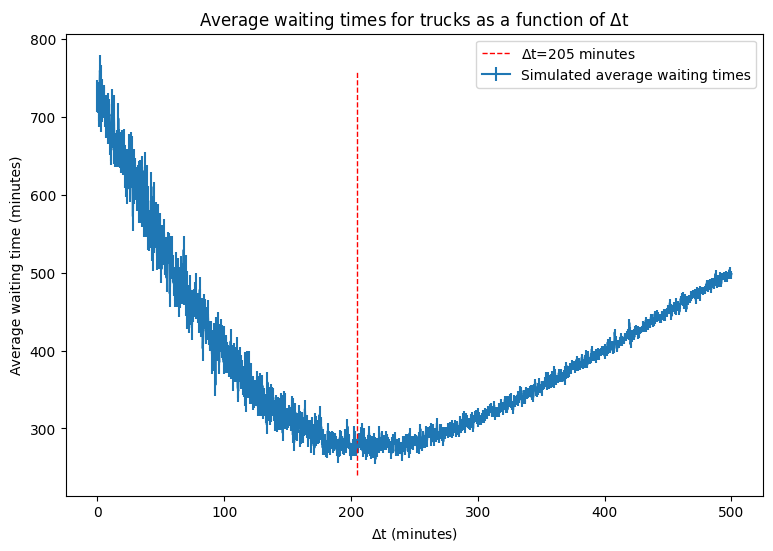

In [1292]:
optimal = 205
plt.figure(figsize=(9,6))
plt.errorbar(del_t, average_waiting, yerr=sig_average_waiting, label="Simulated average waiting times")
plt.plot((optimal,optimal), (np.min(average_waiting)-20, np.max(average_waiting)), "r--", lw="1.0", label=rf"$\Delta$t={optimal} minutes")
plt.xlabel(r"$\Delta$t (minutes)")
plt.ylabel("Average waiting time (minutes)")
plt.title(r"Average waiting times for trucks as a function of $\Delta$t")
plt.legend()

Text(0.5, 0, 'time (minutes)')

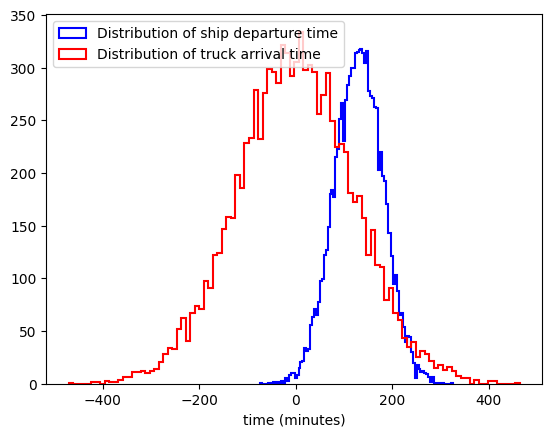

In [1293]:
x_ship = np.random.normal(loc=mu_ship, scale=sig_ship, size=10000)
x_truck = np.random.normal(loc=mu_truck, scale=sig_truck, size=10000)

plt.hist(x_ship, bins=100, label="Distribution of ship departure time", histtype='step', color='Blue', lw=1.5);
plt.hist(x_truck, bins=100, label="Distribution of truck arrival time", histtype='step', color='Red', lw=1.5);
plt.legend()
plt.xlabel("time (minutes)")

In [1294]:
N_points = 1000
N_try = 0.0

x_accepted = np.zeros(N_points)

for i in range(N_points):

    while True:
        
        N_try += 1

        x_test = np.random.normal(loc=mu_truck, scale=sig_truck)

        y_test = np.random.uniform(0, stats.norm.pdf(x_test, loc=mu_truck, scale=sig_truck))

        if y_test > stats.norm.pdf(x_test, loc=mu_ship, scale=sig_ship) and x_test > mu_ship:
            break
    
    x_accepted[i] = x_test

        

The fraction of containers that has to wait is 0.010630155625478357


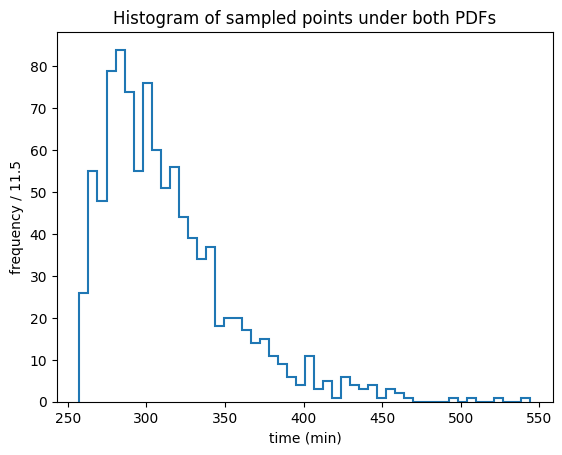

In [1295]:
plt.hist(x_accepted, bins=50, histtype='step', lw=1.5, range=(np.min(x_accepted),np.max(x_accepted)));
plt.xlabel("time (min)")
plt.ylabel(f"frequency / {(np.max(x_accepted)-np.min(x_accepted))/25:.1f}")
plt.title("Histogram of sampled points under both PDFs")

eff = N_points / N_try
print(f"The fraction of containers that has to wait is {eff}")

### Problem 3.2

In [1296]:
def Rayleigh_pdf(x, sigma):
    return x / sigma**2 * np.exp(-1/2 * x**2 / sigma**2)

I will use a combination of the transformation method and the accept-reject method to generate random numbers according to this pdf since the x-range is infinite but I can't invert the integrated function.

$$\int_0^x \frac{x}{\sigma^2} \exp(-\frac{1}{2} \frac{x^2}{\sigma^2}) dx = 1 - \exp(-\frac{1}{2} \frac{x^2}{\sigma^2}) = r$$

I start by plotting the function:

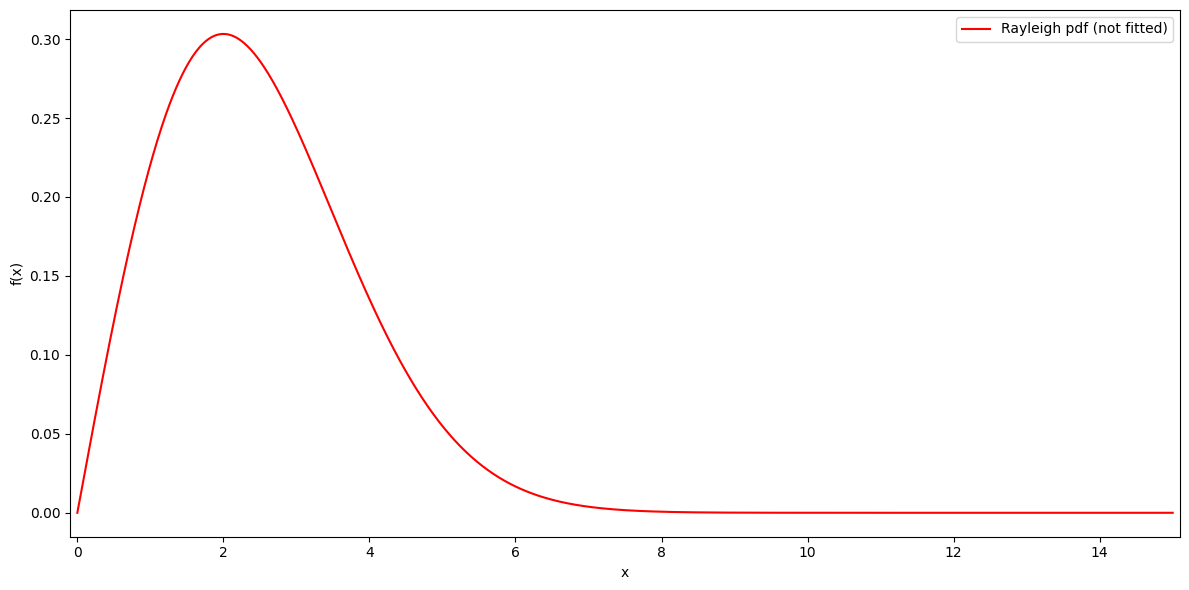

In [1297]:
# I start by plotting the function
xmin = 0
xmax = 15

fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="x", ylabel="f(x)", xlim=(xmin-0.1, xmax+0.1));

# Plot f(x)
x_axis = np.linspace(xmin, xmax, 1000)
y_axis = Rayleigh_pdf(x_axis, sigma=2)
ax.plot(x_axis, y_axis, 'r-', label='Rayleigh pdf (not fitted)')

# Add legend
ax.legend(loc='best')
fig.tight_layout()

I need a function that encloses the Rayleigh pdf to sample under. I define such a function and plot it.

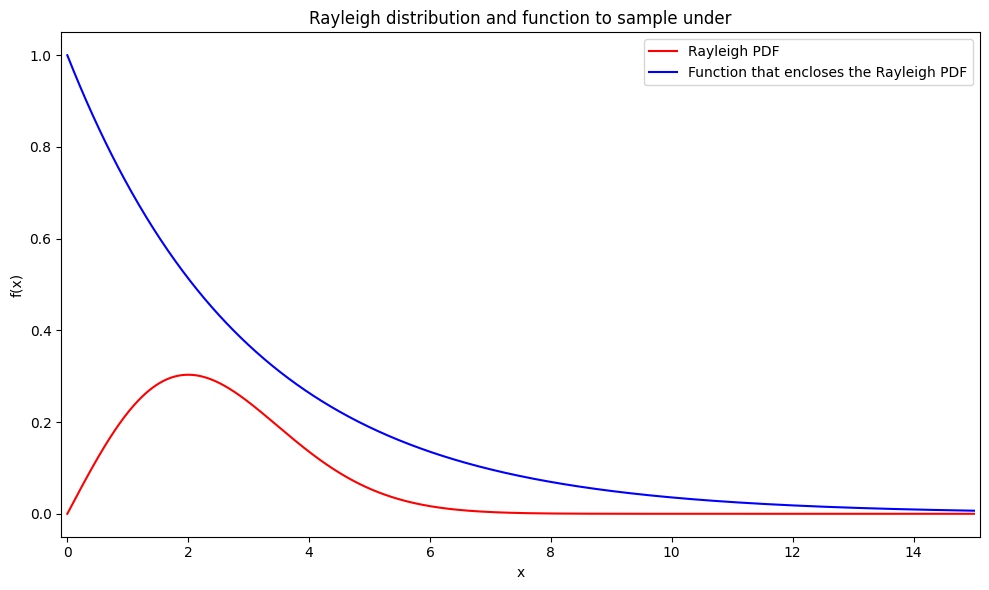

In [1298]:
def f(x, b=1/3):
    return np.exp(-b*x)

# I start by plotting the function
xmin = 0
xmax = 15

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlabel="x", ylabel="f(x)", xlim=(xmin-0.1, xmax+0.1), title="Rayleigh distribution and function to sample under");

# Plot f(x)
x_axis = np.linspace(xmin, xmax, 1000)
y_axis = Rayleigh_pdf(x_axis, sigma=2)
ax.plot(x_axis, y_axis, 'r-', label='Rayleigh PDF')
ax.plot(x_axis, f(x_axis), "b-", label="Function that encloses the Rayleigh PDF")

# Add legend
ax.legend(loc='best')
fig.tight_layout()

In [1299]:
x_check = np.linspace(0,1000,1000)

check = f(x_check) > Rayleigh_pdf(x_check, sigma=2)

false_counter = 0

for i in range(len(check)):
    if check[i] == False:
        false_counter += 1

print(f"Number of times g(x) did NOT enclose f(x): {false_counter}")

Number of times g(x) did NOT enclose f(x): 0


Hence, I can use this function to sample under. First I normalize it:

$$\int_0^\infty N \exp(-\frac{1}{3} x) dx = 3 N = 1$$

$$N = \frac{1}{3}$$

Then I calculate the transformation:

$$\int_0^x \frac{1}{3} \exp(-\frac{1}{3} x) dx = 1 - \exp(-\frac{1}{3} x) = r$$

$$x = - 3 \ln(1 - r)$$

Now I am ready to use the reject-accept to sample the Rayleigh pdf.

In [1300]:
def accept_reject(N_points):

    N_try = 0
    ymin = 0.0      # Minimum value the function will take!
    x_pdf = np.zeros(N_points)

    for i in range(N_points):
        
        while True:
            
            # Count the number of tries, to get efficiency/integral
            N_try += 1                    
            
            # Range that f(x) is defined/wanted in:
            x_test = - 3 * np.log(1 - np.random.uniform())
            
            # Upper bound for function values:
            y_test = r.uniform(ymin, f(x_test))
            
            if (y_test < Rayleigh_pdf(x_test, sigma=2)):
                break
                
        x_pdf[i] = x_test
        
    return x_pdf

In [1301]:
N_points = 1000
x_pdf = accept_reject(N_points=N_points)

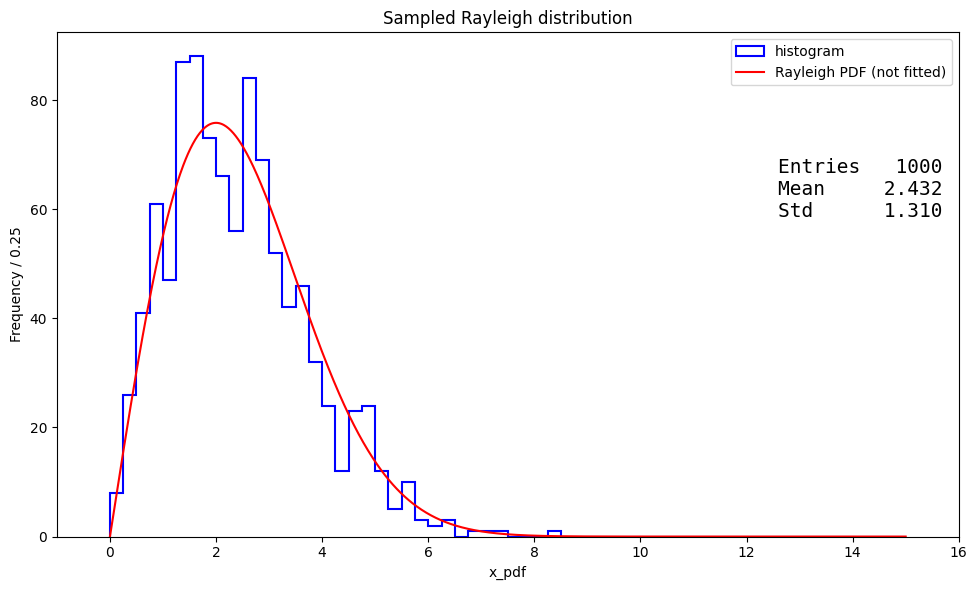

In [1302]:
N_bins = 60
binwidth = (xmax-xmin)/N_bins

def Rayleigh_pdf_hist(x, sigma):
    """This function is for plotting the histogram of the pdf"""
    k = (xmax - xmin) / N_bins
    N = N_points * k
    return N * x / sigma**2 * np.exp(-1/2 * x**2 / sigma**2)

fig4, ax4 = plt.subplots(figsize=(10, 6))
ax4.hist(x_pdf, bins=N_bins, range=(xmin, xmax), histtype='step', color="blue", label='histogram', lw=1.5)
ax4.plot(x_axis, Rayleigh_pdf_hist(x_axis, sigma=2), 'r-', label='Rayleigh PDF (not fitted)')
ax4.set(xlabel="x_pdf", ylabel=f"Frequency / {binwidth:.2f}", xlim=(xmin-1.0, xmax+1.0), title="Sampled Rayleigh distribution");

# Define figure text
d4 = {'Entries': len(x_pdf),
     'Mean': x_pdf.mean(),
     'Std': x_pdf.std(ddof=1),
    }

# Plot figure text
text = nice_string_output(d4, extra_spacing=2, decimals=3)
add_text_to_ax(0.8, 0.75, text, ax4, fontsize=14)

# Add legend
ax4.legend(loc='best')
fig4.tight_layout()

Now I am going to fit the pdf to the sampled points.

In [1303]:
def chi2_fit_function(x_pdf, N_bins):
    # Find the x, y and error on y (sy) given the histogram:
    counts, bin_edges = np.histogram(x_pdf, bins=N_bins, range=(xmin, xmax))
    x = (bin_edges[1:] + bin_edges[:-1])/2
    y = counts
    sy = np.sqrt(counts)   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
                        # This is an approximation, since there is a low count in the last bins.

    # Did you make sure, that all bins were non-zero???
    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

    chi2fit = Chi2Regression(Rayleigh_pdf_hist, x, y, sy)

    # NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

    minuit_chi2 = Minuit(chi2fit, sigma=1.0)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

    return minuit_chi2, x, y, sy

In [1304]:
minuit_chi2, x, y, sy = chi2_fit_function(x_pdf, N_bins)

In [1305]:
 # Short hand way of accessing the fit parameters:
fit_sigma = minuit_chi2.values[:]   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")

Fit value: sigma = 1.91685 +/- 0.03247
Chi2 value: 47.0   Ndof = 29    Prob(Chi2,Ndof) = 0.019


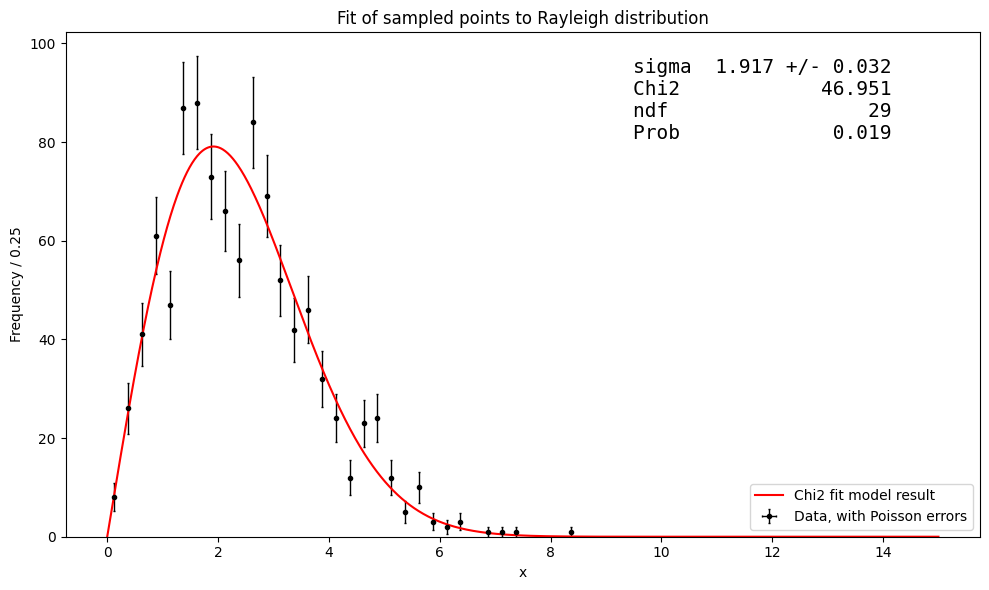

In [1306]:
binwidth = (xmax - xmin) / N_bins

# Create just a single figure and axes, along with a histogram with uncertainties:
fig, ax = plt.subplots(figsize=(10, 6))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="x", # the label of the y axis
       ylabel=f"Frequency / {binwidth:.2f}",  # the label of the y axis
       title="Fit of sampled points to Rayleigh distribution", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero

# Adding fit function to plot:
x_axis = np.linspace(xmin, xmax, 1000)
ax.plot(x_axis, Rayleigh_pdf_hist(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

# Adding fit results to plot:
d = {'sigma':   [minuit_chi2.values['sigma'], minuit_chi2.errors['sigma']],
     'Chi2':     chi2_value,
     'ndf':      Ndof_value,
     'Prob':     Prob_value,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.62, 0.95, text, ax, fontsize=14)
ax.legend(loc='lower right',); # could also be # loc = 'upper right' e.g.
fig.tight_layout()

Next, I am going to test the $1/\sqrt{N}$ scaling of the $\sigma$ fit uncertainty for N between 50 and 50000.

In [1307]:
def sample_and_fit(N_points):
    x_pdf = accept_reject(N_points=N_points)
    minuit_chi2_scaling, _, _, _ = chi2_fit_function(x_pdf, N_bins=int(N_points/10))
    return minuit_chi2_scaling

N_values = np.arange(50, 5050, 50)
print(len(N_values))

sigma_array = np.zeros(len(N_values))
for i, N in enumerate(N_values):
    minuit_chi2_scaling = sample_and_fit(N)
    sigma_array[i] = minuit_chi2_scaling.errors['sigma']

100


In [1308]:
def scaling(N, a):
    return a * 1/np.sqrt(N)

Text(0.5, 1.0, 'Error on sigma from the fit as a function of N')

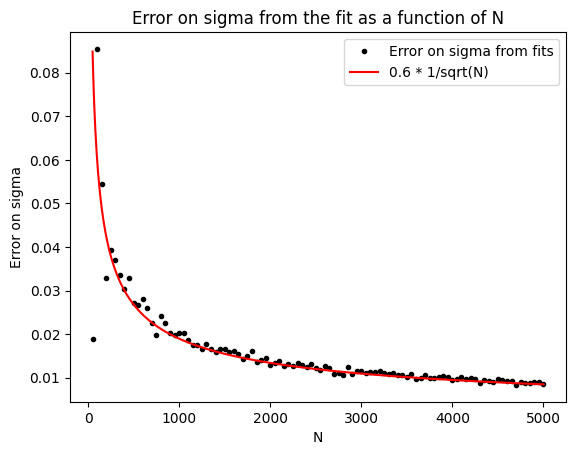

In [1309]:
N_axis = np.linspace(50, 5000, 1000)
plt.plot(N_values, sigma_array, "k.", label="Error on sigma from fits")
plt.plot(N_axis, scaling(N_axis, a=0.6), "r-", label="0.6 * 1/sqrt(N)")
plt.legend()
#plt.ylim((0, 0.03))
plt.xlabel("N")
plt.ylabel("Error on sigma")
plt.title("Error on sigma from the fit as a function of N")

### Problem 4.1

In [1310]:
data = np.genfromtxt("data_AnorocDisease.csv", skip_header=1, delimiter=",")

patient_ID = data[:,0]
temp = data[:,1]
blood_pressure = data[:,2]
age = data[:,3]
status = data[:,4]

In [1311]:
def calc_separation(x, y):
    
    d = np.abs(x.mean() - y.mean()) / np.sqrt(x.std(ddof=1)**2 + y.std(ddof=1)**2)
    
    return d

Text(0, 0.5, 'Frequency / 4.78')

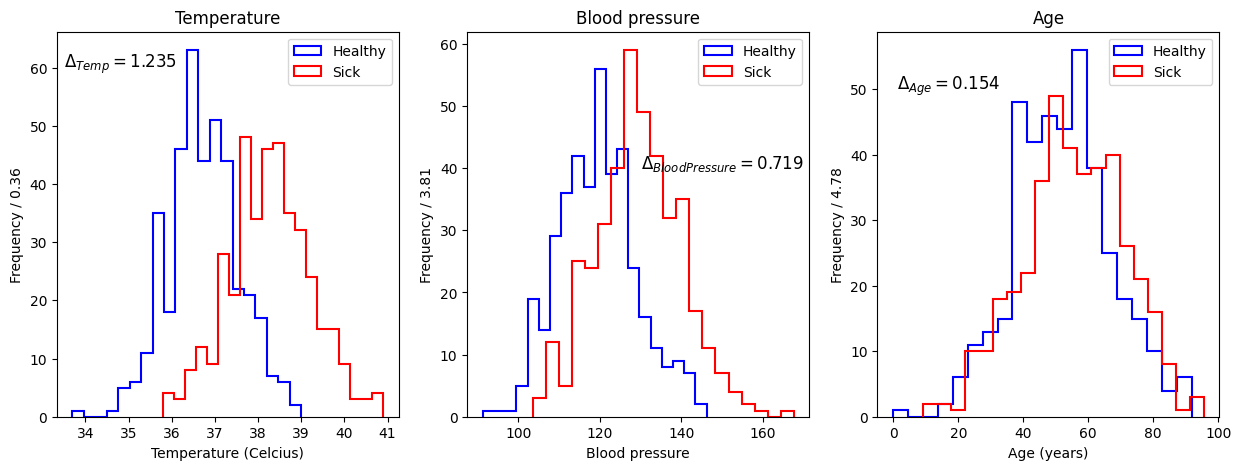

In [1312]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))

ax[0].hist(temp[status==0.0], bins=20, label="Healthy", histtype='step', color='Blue', lw=1.5);
ax[1].hist(blood_pressure[status==0], bins=20, label="Healthy", histtype='step', color='Blue', lw=1.5);
ax[2].hist(age[status==0.0], bins=20, label="Healthy", histtype='step', color='Blue', lw=1.5);
ax[0].hist(temp[status==1.0], bins=20, label="Sick", histtype='step', color='Red', lw=1.5);
ax[1].hist(blood_pressure[status==1.0], bins=20, label="Sick", histtype='step', color='Red', lw=1.5);
ax[2].hist(age[status==1.0], bins=20, label="Sick", histtype='step', color='Red', lw=1.5);

ax[0].legend()
ax[0].set_title("Temperature")
ax[0].text(33.5, 60, fr'$\Delta_{{Temp}} = {calc_separation(temp[status==1.0], temp[status==0.0]):.3f}$', fontsize=12)
ax[0].set_xlabel("Temperature (Celcius)")
ax[0].set_ylabel(f"Frequency / {(np.max(temp[status==1.0])-np.min(temp[status==0.0]))/20:.2f}")

ax[1].legend()
ax[1].set_title("Blood pressure")
ax[1].text(130, 40, fr'$\Delta_{{BloodPressure}} = {calc_separation(blood_pressure[status==1.0], blood_pressure[status==0.0]):.3f}$', fontsize=12)
ax[1].set_xlabel("Blood pressure")
ax[1].set_ylabel(f"Frequency / {(np.max(blood_pressure[status==1.0])-np.min(blood_pressure[status==0.0]))/20:.2f}")

ax[2].legend()
ax[2].set_title("Age")
ax[2].text(1, 50, fr'$\Delta_{{Age}} = {calc_separation(age[status==1.0], age[status==0.0]):.3f}$', fontsize=12)
ax[2].set_xlabel("Age (years)")
ax[2].set_ylabel(f"Frequency / {(np.max(age[status==1.0])-np.min(age[status==0.0]))/20:.2f}")

Hence, of the three single variables, the temperature gives the highest separation between healthy and sick

In [1313]:
p_ks_temp = stats.ks_2samp(temp[status==0.0], temp[status==1.0])[1]
p_ks_blood_pressure = stats.ks_2samp(blood_pressure[status==0.0], blood_pressure[status==1.0])[1]
p_ks_age = stats.ks_2samp(age[status==0.0], age[status==1.0])[1]

print(f"Temperature: p = {p_ks_temp}")
print(f"Blood pressure: p = {p_ks_blood_pressure}")
print(f"Age: p = {p_ks_age}")

Temperature: p = 4.088879750911276e-74
Blood pressure: p = 1.4246329248499256e-33
Age: p = 0.0017621899205092087


Because of the low p-values, I reject the null-hypothesis that the distributions between healthy and sick are statistically the same.

In [1314]:
data_healthy = np.array([temp[status==0.0], blood_pressure[status==0.0], age[status==0.0]])
data_sick = np.array([temp[status==1.0], blood_pressure[status==1.0], age[status==1.0]])

covmat_healthy = np.cov(data_healthy, ddof=1)
covmat_sick = np.cov(data_sick, ddof=1)

# The calculations requires the inverted COMBINED covariance matrices:
print("Combined covariance matrix:")
covmat_comb = covmat_healthy + covmat_sick
print(covmat_comb)
print("")

print("Inverted combined covariance matrix:")
covmat_comb_inv = np.linalg.inv(covmat_comb)
print(covmat_comb_inv)
print("")

wf = covmat_comb_inv @ (data_healthy.mean(axis=1) - data_sick.mean(axis=1))
print(wf)

Combined covariance matrix:
[[  1.55895013   4.65056216  -3.72798534]
 [  4.65056216 198.22746441  14.47339486]
 [ -3.72798534  14.47339486 463.55324649]]

Inverted combined covariance matrix:
[[ 7.07177822e-01 -1.70450196e-02  6.21945348e-03]
 [-1.70450196e-02  5.46707033e-03 -3.07776188e-04]
 [ 6.21945348e-03 -3.07776188e-04  2.21687715e-03]]

[-0.93810394 -0.02806819 -0.01381178]


In [1315]:
fisher_data_healthy = np.zeros(len(data_healthy[0, :]))  # fill in yourself
for i in range(len(data_healthy[0, :])):
    fisher_data_healthy[i] = np.dot(wf, data_healthy[:, i])

fisher_data_sick = np.zeros(len(data_sick[0, :]))  # fill in yourself
for i in range(len(data_sick[0, :])):
    fisher_data_sick[i] = np.dot(wf, data_sick[:, i])

print(len(fisher_data_healthy))
print(f"The separation between the samples is: {calc_separation(fisher_data_healthy, fisher_data_sick):.3f}") 

400
The separation between the samples is: 1.333


0.0


Text(-44, 50, '$\\Delta_{Temp} = 1.333$')

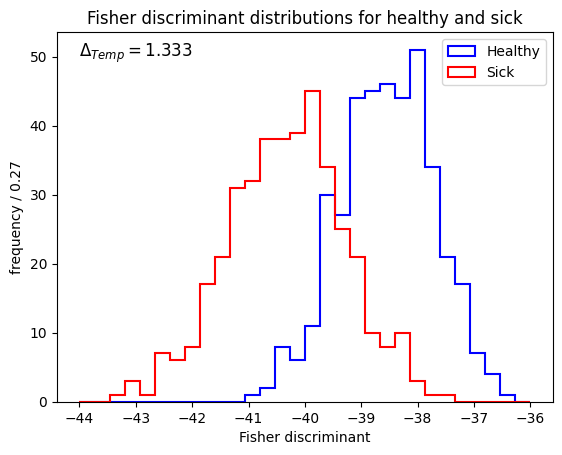

In [1316]:
Nbins = 30
xmin = -44.0
xmax = -36.0
binwidth = (xmax-xmin)/Nbins

hist_healthy = np.histogram(fisher_data_healthy, bins=Nbins, range=(xmin,xmax))
hist_sick = np.histogram(fisher_data_sick, bins=Nbins, range=(xmin,xmax))

x = (hist_healthy[1][1:] + hist_healthy[1][:-1])/2

print(np.sum(hist_healthy[0][:10])/len(fisher_data_healthy))
#print(hist_healthy)
#print(np.sum(hist_sick[:10])/len(fisher_data_sick))
#print(hist_sick)


plt.figure()
plt.hist(fisher_data_healthy, bins=Nbins, label="Healthy", histtype='step', color='Blue', lw=1.5, range=(xmin,xmax));
plt.hist(fisher_data_sick, bins=Nbins, label="Sick", histtype='step', color='Red', lw=1.5, range=(xmin,xmax));
plt.xlabel("Fisher discriminant")
plt.ylabel(f"frequency / {(xmax-xmin)/Nbins:.2f}")
plt.legend()
plt.title("Fisher discriminant distributions for healthy and sick")
plt.text(-44, 50, fr'$\Delta_{{Temp}} = {calc_separation(fisher_data_healthy, fisher_data_sick):.3f}$', fontsize=12)

In [1321]:
FPR, TPR = calc_ROC(np.histogram(fisher_data_healthy, bins=Nbins, range=(xmin,xmax)), np.histogram(fisher_data_sick, bins=Nbins, range=(xmin,xmax)))

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  8,  6, 11, 30,
        27, 44, 45, 46, 44, 51, 34, 21, 17,  7,  4,  1,  0]),
 array([-44.        , -43.73333333, -43.46666667, -43.2       ,
        -42.93333333, -42.66666667, -42.4       , -42.13333333,
        -41.86666667, -41.6       , -41.33333333, -41.06666667,
        -40.8       , -40.53333333, -40.26666667, -40.        ,
        -39.73333333, -39.46666667, -39.2       , -38.93333333,
        -38.66666667, -38.4       , -38.13333333, -37.86666667,
        -37.6       , -37.33333333, -37.06666667, -36.8       ,
        -36.53333333, -36.26666667, -36.        ]))

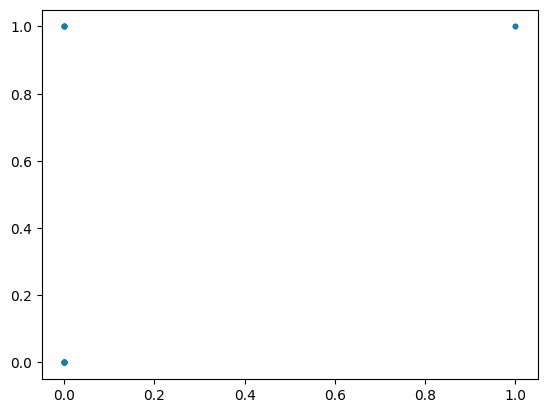

In [1325]:
plt.plot(FPR, TPR, ".")
np.histogram(fisher_data_healthy, bins=Nbins, range=(xmin,xmax))

0.9625
-38.4
[ 0  0  1  3  1  7  6  8 17 21 31 32 38 38 39 45 34 25 21 10  8]


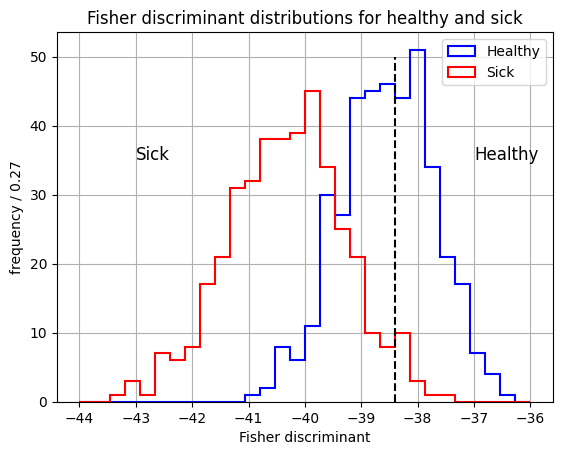

In [ ]:
#print(np.sum(hist_healthy[0]))
#print(len(fisher_data_healthy))

i = 21
print(np.sum(hist_sick[0][:i])/np.sum(hist_sick[0]))
print(hist_sick[1][21])
print(hist_sick[0][:21])

plt.hist(fisher_data_healthy, bins=Nbins, label="Healthy", histtype='step', color='Blue', lw=1.5, range=(xmin,xmax));
plt.hist(fisher_data_sick, bins=Nbins, label="Sick", histtype='step', color='Red', lw=1.5, range=(xmin,xmax));
plt.plot((hist_sick[1][21], hist_sick[1][21]), (0,50), linestyle="--", color="black")
plt.xlabel("Fisher discriminant")
plt.ylabel(f"frequency / {(xmax-xmin)/Nbins:.2f}")
plt.legend()
plt.title("Fisher discriminant distributions for healthy and sick")
plt.text(-43, 35, 'Sick', fontsize=12)
plt.text(-37, 35, 'Healthy', fontsize=12)
plt.grid()

In [ ]:
data_unknown = np.array([temp[status==-1.0], blood_pressure[status==-1.0], age[status==-1.0]])

fisher_data_unknown = np.zeros(len(data_unknown[0, :]))  # fill in yourself
for i in range(len(data_unknown[0, :])):
    fisher_data_unknown[i] = np.dot(wf, data_unknown[:, i])

133
0.665


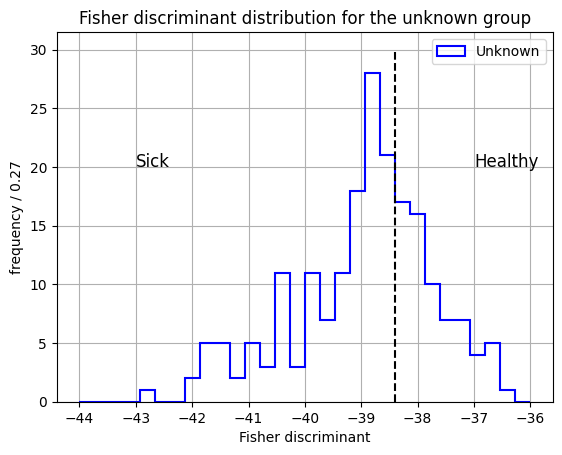

In [ ]:
hist_unknown = np.histogram(fisher_data_unknown, bins=Nbins, range=(xmin,xmax))

i = 21
print(np.sum(hist_unknown[0][:i]))
print(np.sum(hist_unknown[0][:i])/np.sum(hist_unknown[0]))

plt.hist(fisher_data_unknown, bins=Nbins, label="Unknown", histtype='step', color='Blue', lw=1.5, range=(xmin,xmax));
plt.plot((hist_sick[1][21], hist_sick[1][21]), (0,30), linestyle="--", color="black")
plt.xlabel("Fisher discriminant")
plt.ylabel(f"frequency / {(xmax-xmin)/Nbins:.2f}")
plt.legend()
plt.title("Fisher discriminant distribution for the unknown group")
plt.text(-43, 20, 'Sick', fontsize=12)
plt.text(-37, 20, 'Healthy', fontsize=12)
plt.grid()

In [ ]:
temp_sick = temp[status==1.0]

sick_high_temp = len(temp_sick[temp_sick>=38.5])

L = sick_high_temp/len(temp_sick)
print(L)

0.42


In [ ]:
temp_healthy = temp[status==0.0]

healthy_high_temp = len(temp_healthy[temp_healthy>=38.5])

M = sick_high_temp/len(temp_sick) * len(status[status==1.0])/(len(status[status==0.0])+len(status[status==1.0])) + healthy_high_temp/len(temp_healthy) * len(status[status==0.0])/(len(status[status==0.0])+len(status[status==1.0]))
print(M)

0.22


In [ ]:
M2 = (sick_high_temp+healthy_high_temp) / (len(status[status==0.0])+len(status[status==1.0]))
print(M2)

0.22


In [ ]:
M3 = (len(temp_healthy[temp_healthy>=38.5])+len(temp_sick[temp_sick>=38.5])) / (len(status[status==0.0])+len(status[status==1.0]))
print(M3)

0.22


In [ ]:
prior = 0.01

print(f"Probability = {prior*L/M}")

Probability = 0.01909090909090909


### Problem 4.2

In [ ]:
data = np.genfromtxt("data_CountryScores.csv", delimiter=",", skip_header=1)

GDP = data[:,1]
pop_size = data[:,2]
happiness_index = data[:,3]
economic_freedom_index = data[:,4]
press_freedom_index = data[:,5]
education_index = data[:,6]

In [ ]:
GDP_mean = np.mean(GDP)
GDP_median = np.median(GDP)
GDP_sigma = np.std(GDP, ddof=1)
GDP_15_87_q = np.quantile(GDP, 15.87/100)
GDP_84_13_q = np.quantile(GDP, 84.13/100)

print(f"The mean of the GDP is {GDP_mean:.2f}.")
print(f"The median of the GDP is {GDP_median}.")
print(f"The standard deviation of the GDP is {GDP_sigma:.2f}.")
print(f"The 15.87 % quantile of the GDP is {GDP_15_87_q:.2f}.")
print(f"The 84.13 % quantile of the GDP is {GDP_84_13_q:.2f}.")

The mean of the GDP is 17362.05.
The median of the GDP is 6677.0.
The standard deviation of the GDP is 23840.25.
The 15.87 % quantile of the GDP is 1187.23.
The 84.13 % quantile of the GDP is 40850.23.


Text(0, 0.5, 'frequency / 0.18')

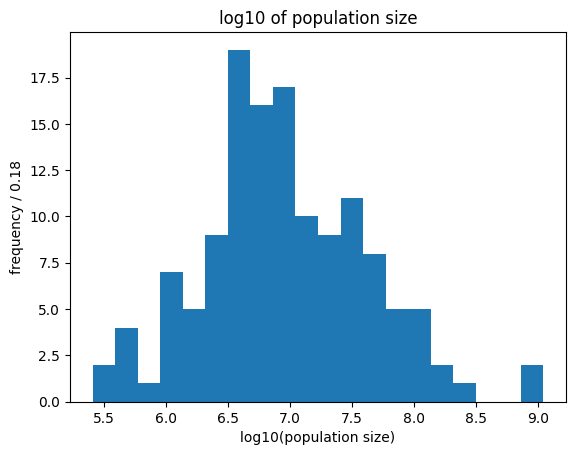

In [ ]:
xmin = np.min(np.log10(pop_size))
xmax = np.max(np.log10(pop_size))
Nbins = 20
binwidth = (xmax - xmin)/Nbins

plt.hist(np.log10(pop_size), bins=Nbins, range=(xmin, xmax),);
plt.title("log10 of population size");
plt.xlabel("log10(population size)")
plt.ylabel(f"frequency / {binwidth:.2f}")

In [ ]:
custom_normal_dist = stats.norm(loc=np.mean(np.log10(pop_size)), scale=np.std(np.log10(pop_size)))

p_ks = stats.kstest(np.log10(pop_size), custom_normal_dist.cdf)[1]
print(f"Kolmogorov-Smirnov test: p = {p_ks}")

Kolmogorov-Smirnov test: p = 0.2879474265774511


In [ ]:
# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(np.log10(pop_size), bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
                       # This is an approximation, since there is a low count in the last bins.

# Did you make sure, that all bins were non-zero???
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
print(len(y))
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

18


In [ ]:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    N = (xmax-xmin)/Nbins * len(np.log10(pop_size))
    return  N * 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)


chi2_gaussian = Chi2Regression(gauss_pdf, x, y, sy)
chi2_gaussian.errordef = 1
minuit_gaussian = Minuit(chi2_gaussian, mu=0.0, sigma=1.0) #   
minuit_gaussian.migrad();       # Perform the actual fit
Chi2_gau = minuit_gaussian.fval
Ndof_gau = len(x) - 2           # 3 parameters in fit
print(Ndof_gau)
Prob_gau = stats.chi2.sf(Chi2_gau, Ndof_gau)

16


6.995442675310826 0.623691081370795
0.05512309516513965 0.04925390803455445


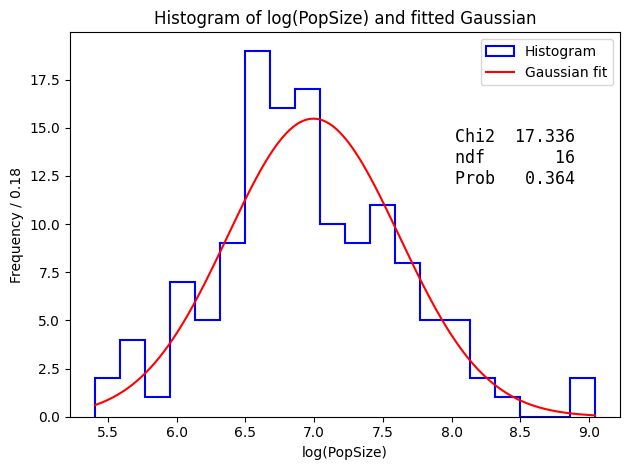

In [ ]:
xaxis = np.linspace(xmin, xmax, 1000)

yaxis = gauss_pdf(xaxis, *minuit_gaussian.values[:])

fig, ax = plt.subplots()
ax.hist(np.log10(pop_size), bins=Nbins, histtype='step', color='Blue', lw=1.5, range=(xmin, xmax), label="Histogram");
ax.plot(xaxis, yaxis, 'r-', label='Gaussian fit')
ax.legend()
ax.set(xlabel="log(PopSize)", ylabel=f"Frequency / {(xmax-xmin)/Nbins:.2f}", title="Histogram of log(PopSize) and fitted Gaussian")

d = {'Chi2':     Chi2_gau  ,
    'ndf':      Ndof_gau,
    'Prob':     Prob_gau,
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.7, 0.75, text, ax, fontsize=12)
fig.tight_layout()

print(*minuit_gaussian.values[:])
print(*minuit_gaussian.errors[:])

In [ ]:
pearson = stats.pearsonr(happiness_index, education_index)
spearman = stats.spearmanr(happiness_index, education_index)

print(f"Pearson correlation = {pearson[0]}")
print(f"Spearman correlation = {spearman[0]}")

Pearson correlation = 0.7647440306793954
Spearman correlation = 0.8043593869327467


Text(0, 0.5, 'Education index')

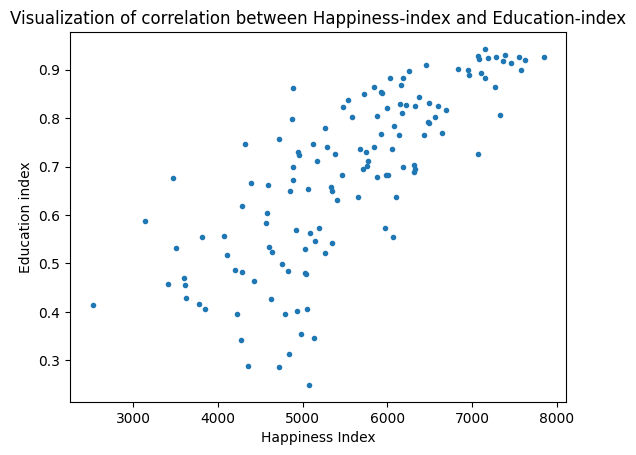

In [ ]:
plt.plot(happiness_index, education_index, ".")
plt.title("Visualization of correlation between Happiness-index and Education-index")
plt.xlabel("Happiness Index")
plt.ylabel("Education index")

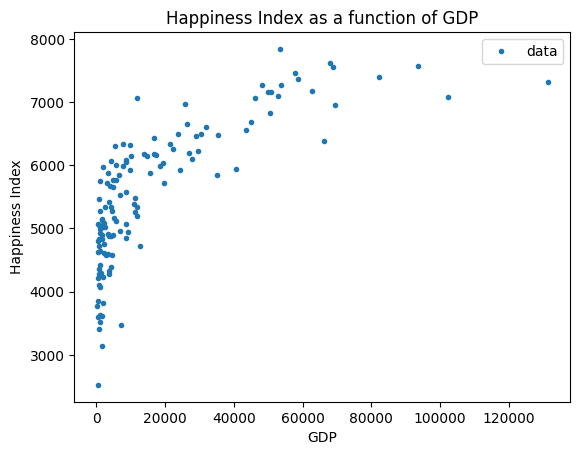

In [ ]:
plt.plot(GDP, happiness_index, ".", label="data")
plt.xlabel("GDP")
plt.ylabel("Happiness Index")
plt.title("Happiness Index as a function of GDP")
plt.legend()

In [ ]:
def fit_function(x, a, b) :
    return  a * np.log(b*x)

chi2 = Chi2Regression(fit_function, GDP, happiness_index, 1.0)
chi2.errordef = 1
minuit = Minuit(chi2, a=1.0, b=2.0) #   
minuit.migrad();       # Perform the actual fit
Chi2 = minuit.fval
Ndof = len(GDP) - 2           # 3 parameters in fit
Prob = stats.chi2.sf(Chi2, Ndof)

/var/folders/bh/qd5vvgrj3dxbcwf3jbzbldrm0000gn/T/ipykernel_1995/121810457.py:2: RuntimeWarning: invalid value encountered in log
  return  a * np.log(b*x)


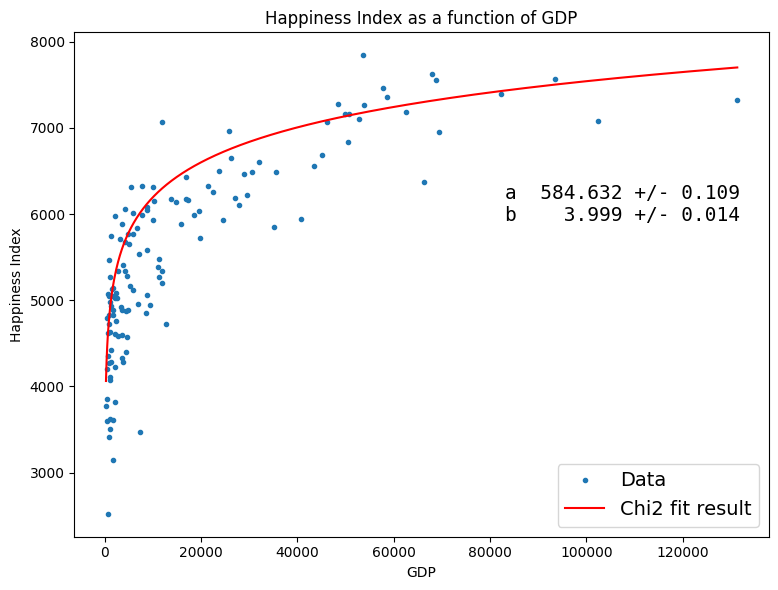

In [ ]:
xaxis = np.linspace(np.min(GDP), np.max(GDP), 1000)
yaxis = fit_function(xaxis, *minuit.values[:])

# Create just a single figure and axes, along with a histogram with uncertainties:
fig, ax = plt.subplots(figsize=(8, 6))  # figsize is in inches
ax.plot(GDP, happiness_index, ".", label="Data")

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="GDP", # the label of the y axis
       ylabel="Happiness Index",  # the label of the y axis
       title="Happiness Index as a function of GDP")

# Adding fit function to plot:
ax.plot(xaxis, yaxis, '-r', label='Chi2 fit result') 

# Adding fit results to plot:
d = {'a':   [minuit.values['a'], minuit.errors['a']],
     'b':       [minuit.values['b'], minuit.errors['b']]}

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.62, 0.70, text, ax, fontsize=14)
ax.legend(loc='lower right', fontsize=14); # could also be # loc = 'upper right' e.g.
fig.tight_layout()

The uncertainty on the Happiness Index is 592.34.


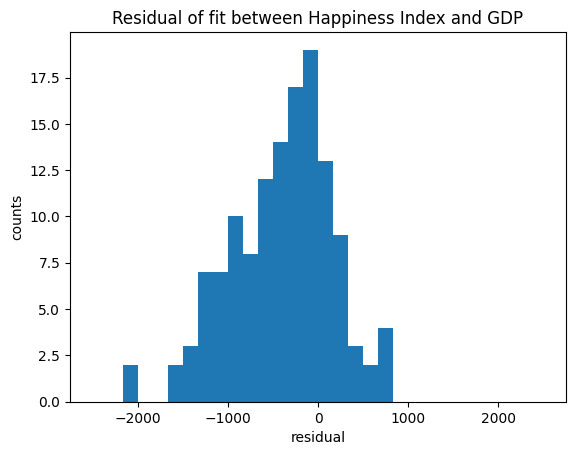

In [ ]:
res = happiness_index - fit_function(GDP, *minuit.values[:])

Nbins = 30
xmin = -2500
xmax = 2500

plt.hist(res, bins=Nbins, range=(xmin, xmax))
plt.xlabel("residual")
plt.ylabel("counts")
plt.title("Residual of fit between Happiness Index and GDP")

sigma_happiness = np.std(res, ddof=1)
print(f"The uncertainty on the Happiness Index is {sigma_happiness:.2f}.")

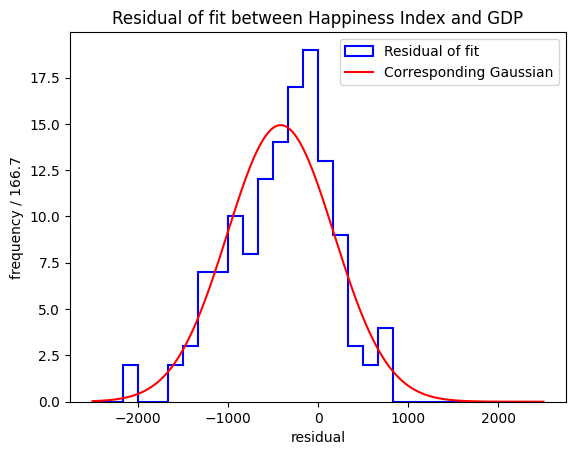

In [ ]:
def gaussian(x, mu, sigma, N=len(GDP), binwidth=(xmax-xmin)/Nbins):
    return N * binwidth / (sigma*np.sqrt(2*np.pi)) * np.exp(-0.5* (x-mu)**2/sigma**2)

xaxis = np.linspace(xmin, xmax, 1000)

plt.hist(res, bins=Nbins, range=(xmin, xmax), label="Residual of fit", histtype="step", color="blue", lw=1.5)
plt.plot(xaxis, gaussian(xaxis, mu=np.mean(res), sigma=sigma_happiness), label="Corresponding Gaussian", color="red")
plt.xlabel("residual")
plt.ylabel(f"frequency / {(xmax-xmin)/Nbins:.1f}")
plt.title("Residual of fit between Happiness Index and GDP")
plt.legend()

### Problem 5.1

In [ ]:
data = np.genfromtxt("data_GlacierSizes.csv", skip_header=1, delimiter=",")

area = data[:, 0]
sig_area = data[:, 1]
volume = data[:, 2]
sig_volume = data[:,3]

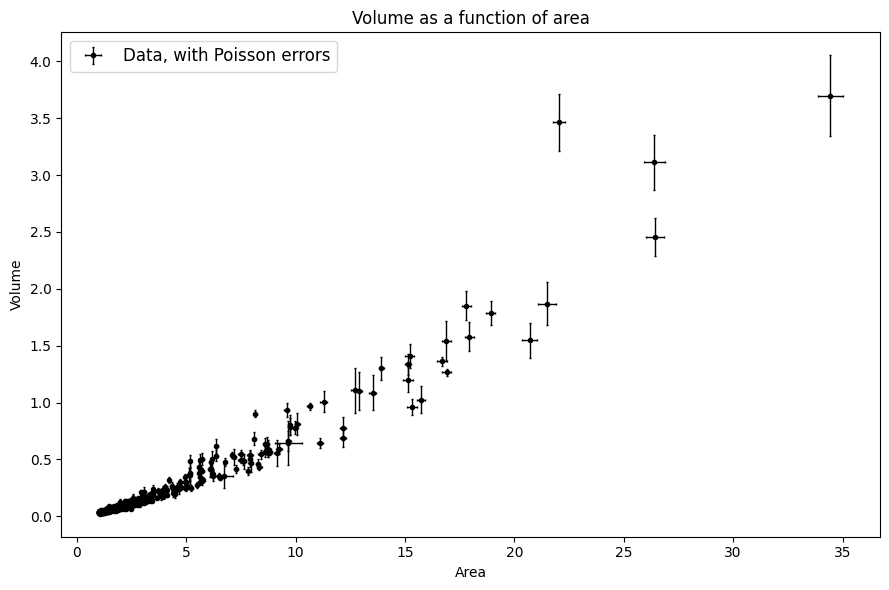

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))  # figsize is in inches
ax.errorbar(area, volume, xerr=sig_area, yerr=sig_volume, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Area", # the label of the y axis
       ylabel="Volume",  # the label of the y axis
       title="Volume as a function of area")


ax.legend(loc='upper left', fontsize=12); # could also be # loc = 'upper right' e.g.
fig.tight_layout()

In [ ]:
print(np.mean(sig_area/area))
print(np.mean(sig_volume/volume))

0.013281048830950434
0.10065155981461331


On the plot I can see that volume generally has larger relative uncertainty than area.

In [ ]:
def fit_and_plot(f, x, y, sy, par_guess, labels):
    Minuit.print_level = 1

    chi2fit = Chi2Regression(f, x, y, sy)

    minuit_chi2 = Minuit(chi2fit, **par_guess)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output


    for name in minuit_chi2.parameters :
        value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value = len(y) - minuit_chi2.nfit

    Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

    fig, ax = plt.subplots(figsize=(9, 6))  # figsize is in inches
    ax.errorbar(area, volume, xerr=0, yerr=sy, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

    # Set the figure texts; xlabel, ylabel and title.
    ax.set(xlabel=f"{labels[0]}", # the label of the y axis
        ylabel=f"{labels[1]}",  # the label of the y axis
        title=f"{labels[2]}")

    # Adding fit function to plot:
    x_axis = np.linspace(np.min(x), np.max(x), 1000)
    ax.plot(x_axis, f(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

    # Adding fit results to plot:
    d = {'Chi2':     minuit_chi2.fval  ,
        'ndf':      len(y)-minuit_chi2.nfit,
        'Prob':     stats.chi2.sf(minuit_chi2.fval, len(y)-minuit_chi2.nfit),
        }

    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.62, 0.95, text, ax, fontsize=12)

    ax.legend(loc='upper left', fontsize=12);
    fig.tight_layout()

    return minuit_chi2.values[:], minuit_chi2.errors[:]

Fit value: a = 0.02522 +/- 0.00008
Chi2 value: 4265.1   Ndof = 433    Prob(Chi2,Ndof) = 0.0


([0.02521747635176554], [8.052267622131625e-05])

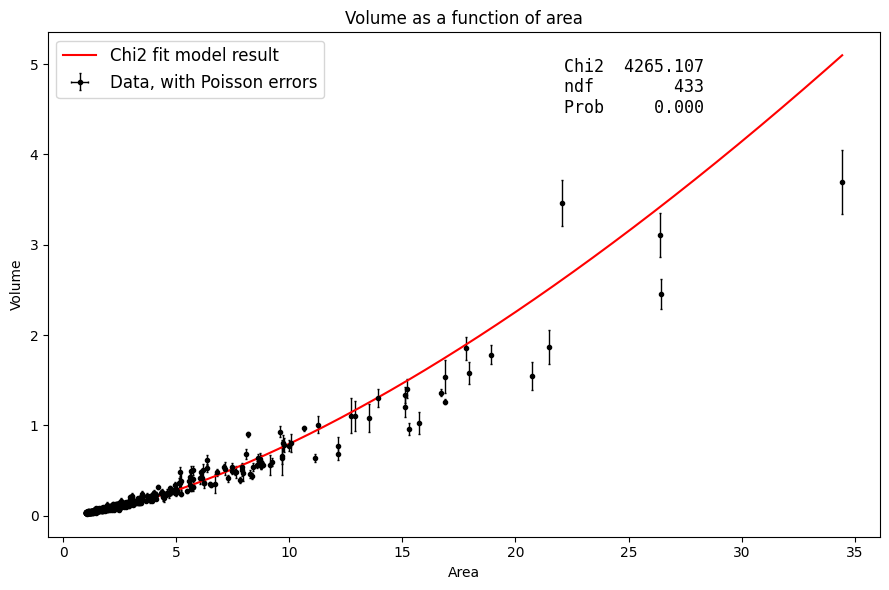

In [ ]:
def V_of_A(A, a):
    return a * A**(3/2)

fit_and_plot(V_of_A, area, volume, sig_volume, {"a":0.0}, ["Area", "Volume", "Volume as a function of area"])

Fit value: a = 0.02249 +/- 0.00014
Fit value: b = 0.00742 +/- 0.00030
Chi2 value: 3636.1   Ndof = 432    Prob(Chi2,Ndof) = 0.0


([0.022490560959856805, 0.007415530686085564],
 [0.00013530085851842438, 0.00029568124780208945])

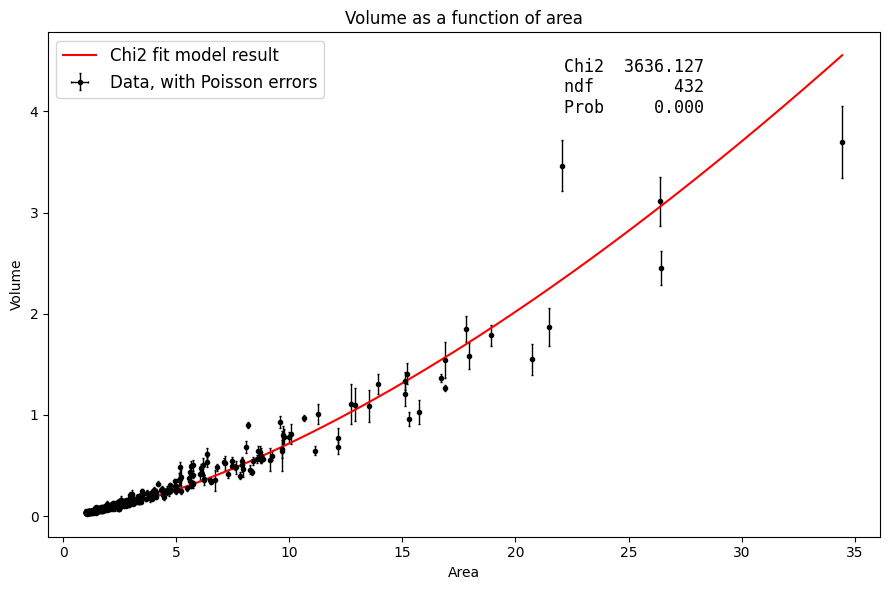

In [ ]:
def V_of_A_new(A, a, b):
    return a * A**(3/2) + b

fit_and_plot(V_of_A_new, area, volume, sig_volume, {"a":0.0, "b":0.0}, ["Area", "Volume", "Volume as a function of area"])

Fit value: a = 0.02249 +/- 0.00014
Fit value: b = 0.00742 +/- 0.00030
Chi2 value: 3636.1   Ndof = 432    Prob(Chi2,Ndof) = 0.0


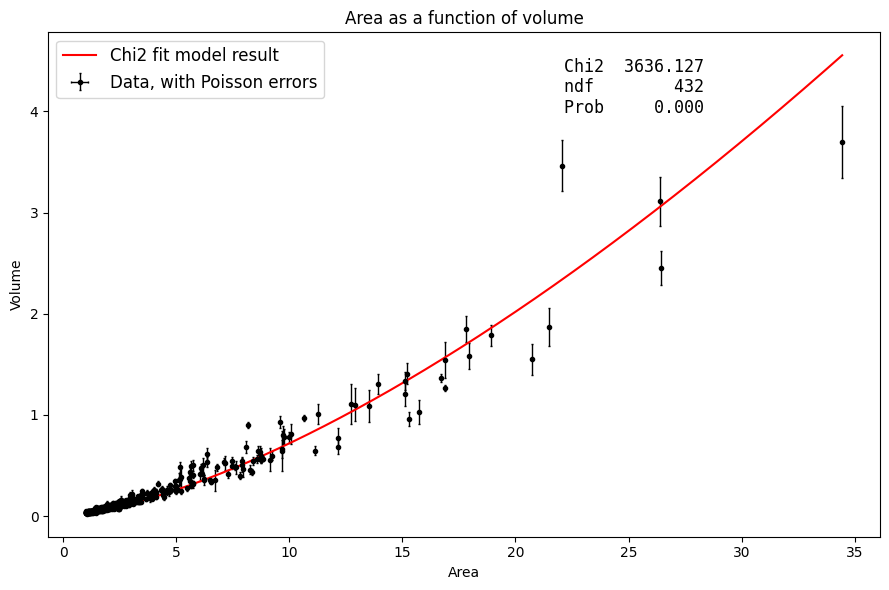

In [ ]:
def V_of_A_new(A, a, b):
    return a * A**(3/2) + b

values, errors = fit_and_plot(V_of_A_new, area, volume, sig_volume, {"a":0.02249, "b":0.1}, ["Area", "Volume", "Area as a function of volume"])

In [ ]:
a, b, A = symbols("a, b, A")

V = a * A**(3/2) + b

dVdA = V.diff(A)

print_relation(dVdA, "dV/dA")

<IPython.core.display.Latex object>

In [ ]:
f_dVdA = lambdify((A, a, b), dVdA)

In [ ]:
dVdA_array = f_dVdA(area, a=values[0], b=values[1])

sig_new = np.sqrt(sig_volume**2 + (dVdA_array * sig_area)**2)

Fit value: a = 0.02350 +/- 0.00015
Fit value: b = 0.00723 +/- 0.00033
Chi2 value: 2687.6   Ndof = 432    Prob(Chi2,Ndof) = 0.0


([0.023495093439774545, 0.007228188707670738],
 [0.00015194654447418769, 0.00033138430219936725])

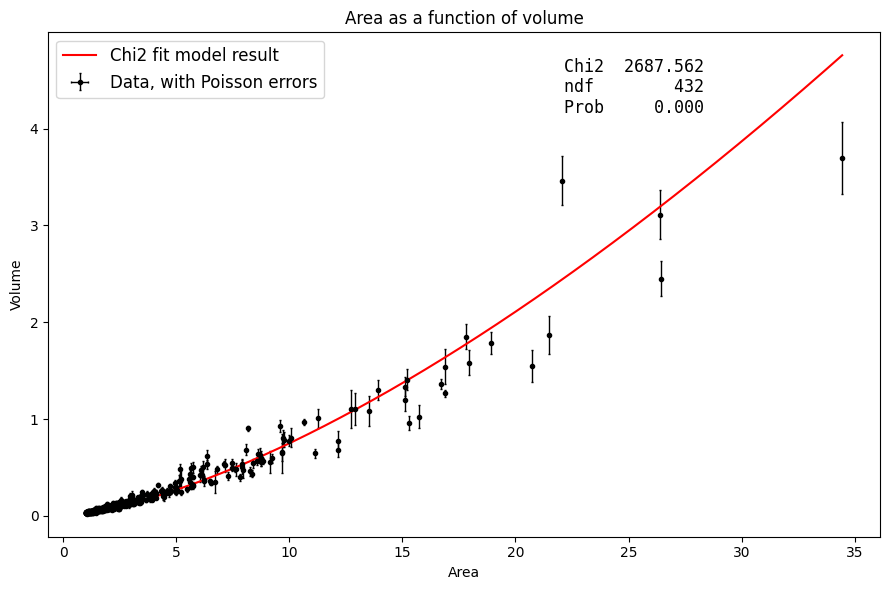

In [ ]:
fit_and_plot(V_of_A_new, area, volume, sig_new, {"a":0.0, "b":0.0}, ["Area", "Volume", "Area as a function of volume"])

In [ ]:
v_a, v_b = values
v_da, v_db = errors

a, b, A = symbols("a, b, A")
da, db = symbols("sigma_a, sigma_b")

V = a * A**(3/2) + b

par = np.array([a, b])
cov = np.array([[da**2, 0], [0, db**2]])

print_relation(V, "V")
dV, _ = propagate_error(V, par, cov)
print_relation(dV, "sigma_V")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
A_eval = 0.5

f_V = lambdify((A, a, b), V)
f_dV = lambdify((A, a, b, da, db), dV)

print(f"V = {f_V(A_eval, a=v_a, b=v_b):.4f} +- {f_dV(A_eval, v_a, v_b, v_da, v_db):.4f}")

V = 0.0154 +- 0.0003
